In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [20]:
HORIZON = 3
SPLITS = 5

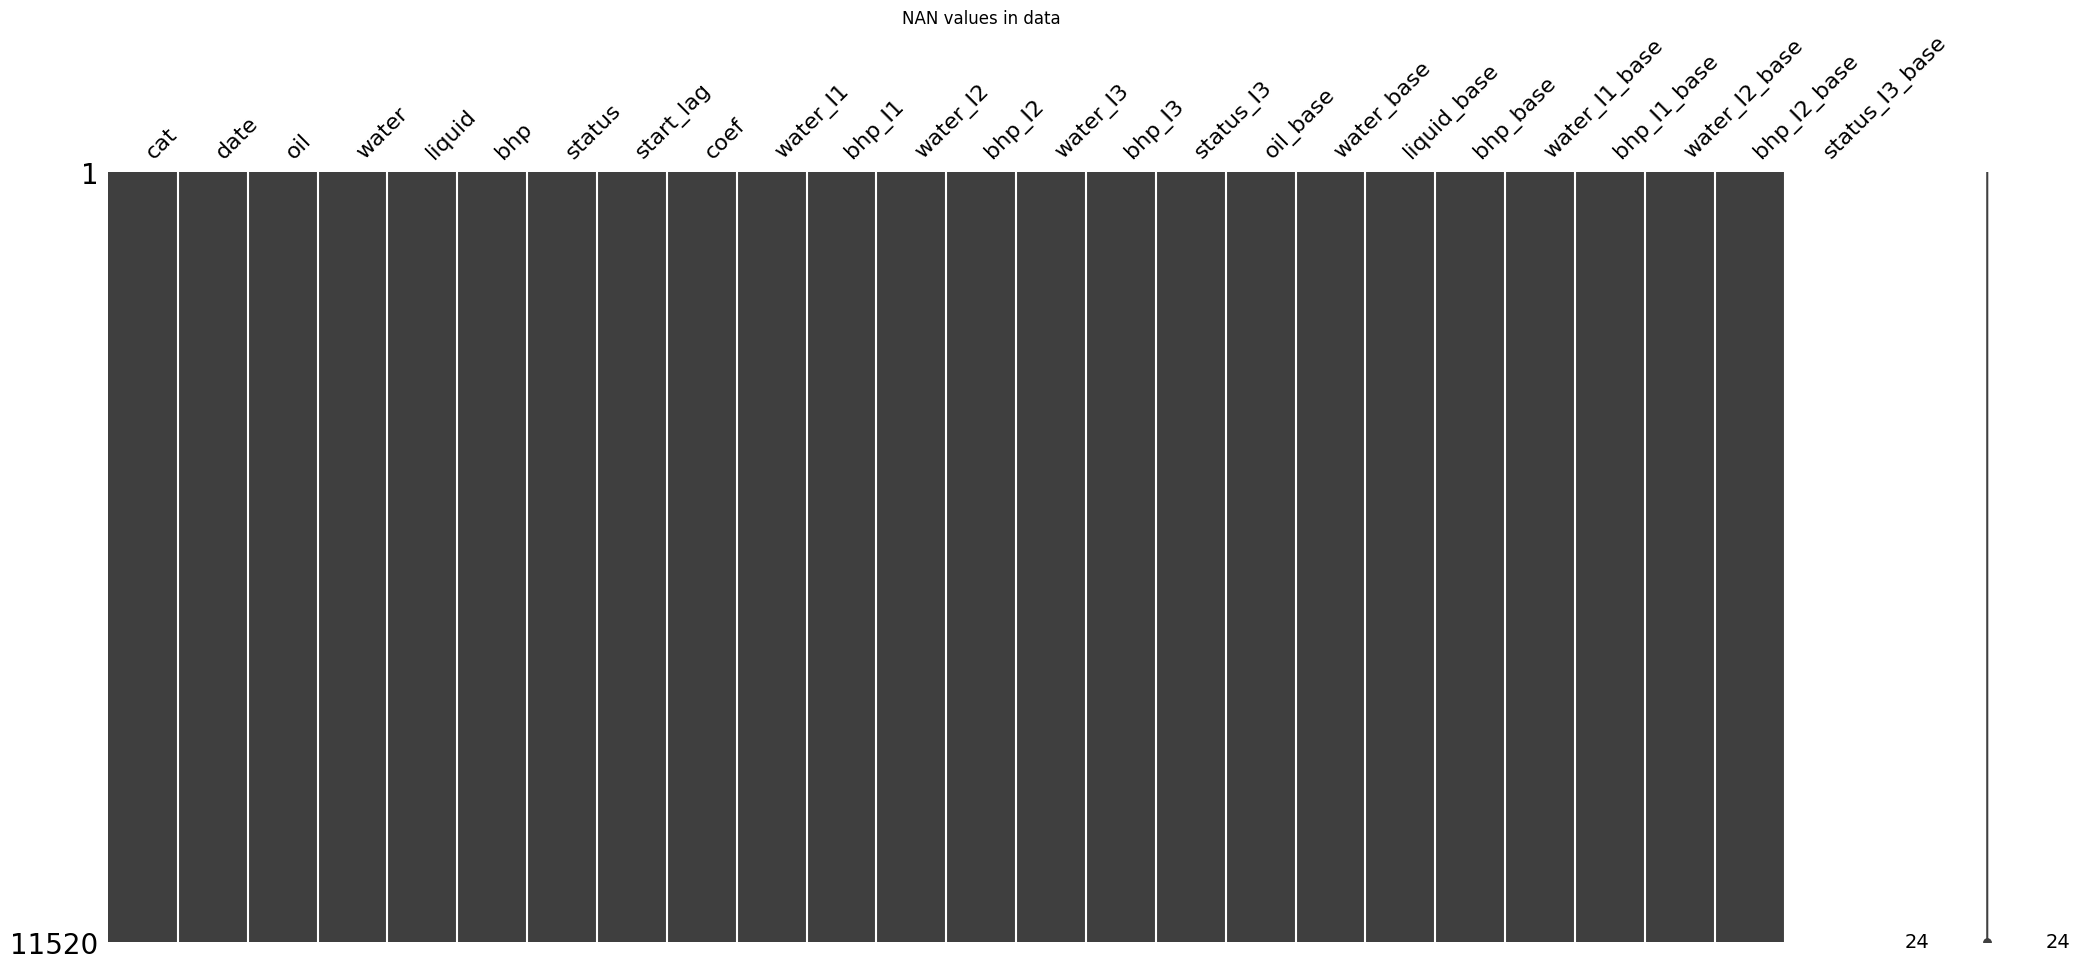

/home/zeinovich/anaconda3/envs/kaggle1/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/zeinovich/anaconda3/envs/kaggle1/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/zeinovich/anaconda3/envs/kaggle1/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeinovich/anaconda3/envs/kaggle1/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


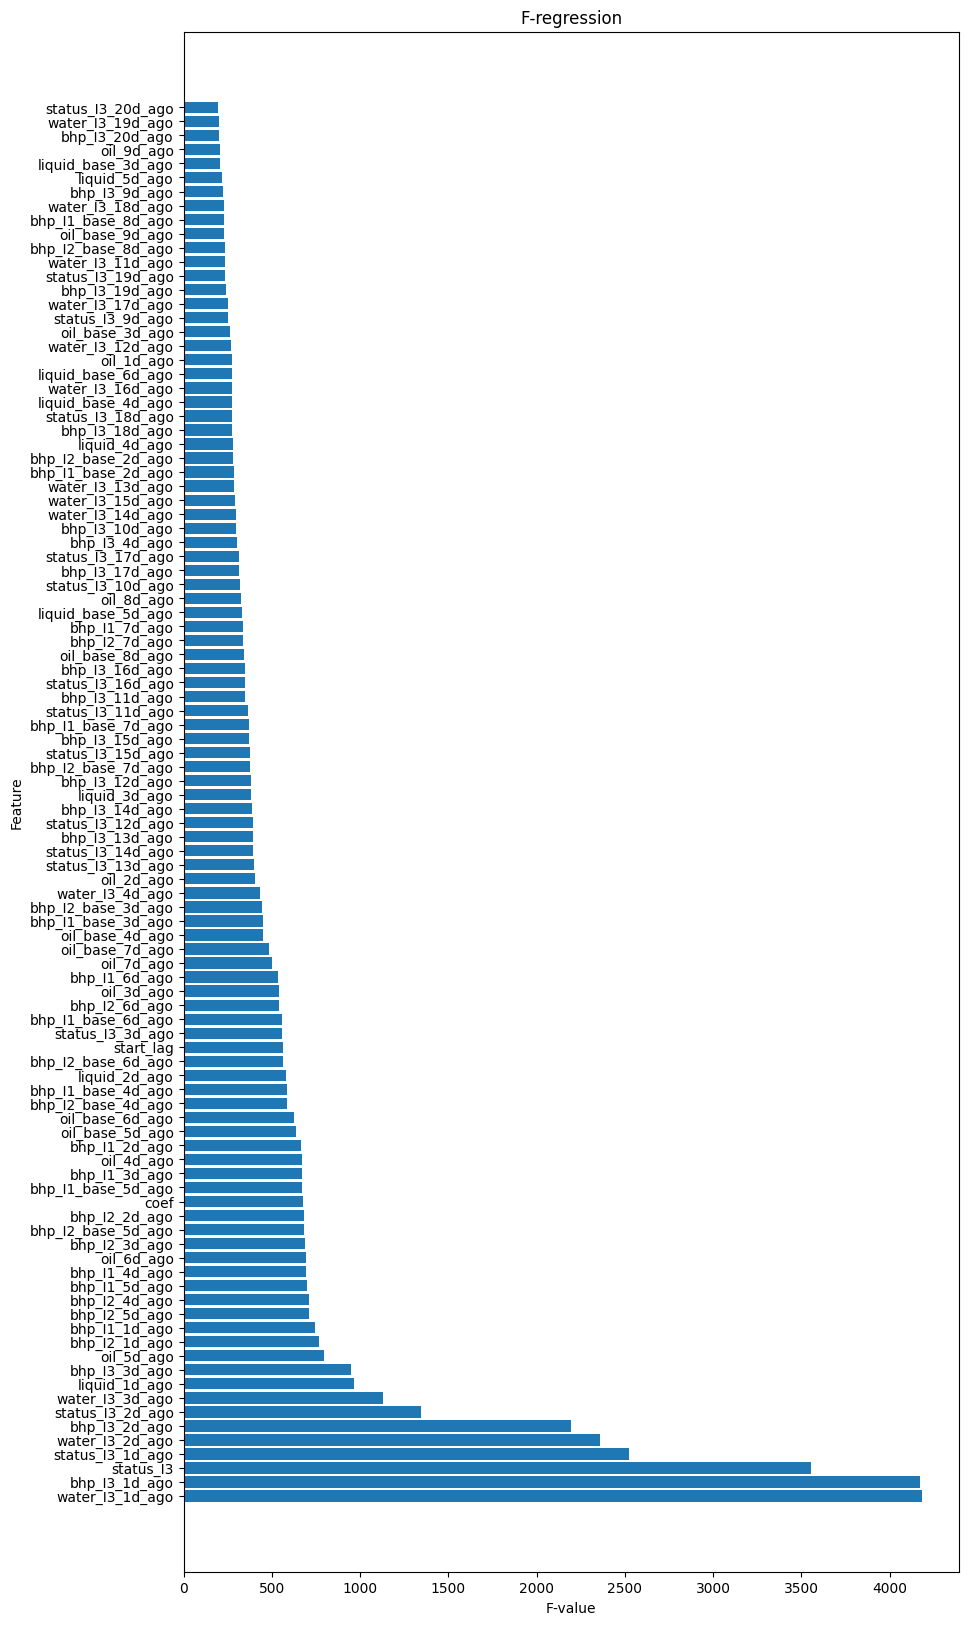

In [10]:
data = pd.read_csv('../data/data.csv')
data = data.fillna(0)

p_data = data[data.group == 'P']
i_data = data[data.group == 'I']

for inj in i_data.cat.unique():
    inj_data = i_data[i_data.cat == inj].drop(columns=['cat', 'group', 
                                                       'oil', 'liquid', 
                                                       'is_base'])
    if inj != 'I3':
        inj_data = inj_data.drop(columns=['status'])
    p_data = p_data.merge(inj_data, 
                          on=['start_lag', 'coef', 'date'], 
                          suffixes=('', f'_{inj}'),
                          how='left')
    
data_init = p_data.copy()

baseline = (data_init[data_init.is_base]
                     .drop('is_base', axis=1)
                     .reset_index(drop=True))

non_baseline = (data_init[~data_init.is_base]
                         .drop('is_base', axis=1)
                         .reset_index(drop=True))

baseline = baseline.drop(columns=['start_lag', 'coef', 'group', 'status', 'water_I3', 'bhp_I3'])

non_baseline = non_baseline.merge(baseline, 
                                  on=['cat', 'date'], 
                                  suffixes=('', '_base'), 
                                  how='left')

non_baseline = non_baseline.drop(columns=['group'])
non_baseline['cat'] = non_baseline['cat'].apply(lambda x: int(x[1]))

msno.matrix(non_baseline)
plt.title('NAN values in data')
plt.show()

sel = VarianceThreshold(threshold=0)

sel.fit(non_baseline.drop(['cat'], axis=1))

cols2keep = non_baseline.drop(['cat'], axis=1).columns[sel.get_support()]

data_clean = non_baseline[['cat'] + list(cols2keep)]

data_lagged = data_clean.copy()

for i in range(1, 28):
    data_lagged = data_lagged.join(data_clean.groupby(['cat', 'start_lag', 'coef'])
                                             .shift(i)
                                             .add_suffix(f'_{i}d_ago')
                                             ).fillna(0)
    
data_lagged['delta_baseline'] = data_lagged['oil'] - data_lagged['oil_base']

data_lagged = data_lagged.drop(['water_I3', 'bhp_I1', 'bhp_I2', 'bhp_I3'], axis=1)

f_reg = f_regression(data_lagged.drop(['oil', 'water', 'liquid', 'delta_baseline'], axis=1), 
                     data_lagged[['delta_baseline']])

f_features = (pd.DataFrame({
                        'feature': (
                                     data_lagged
                                     .drop(['oil', 'water', 'liquid', 'delta_baseline'], axis=1)
                                     .columns
                                     ), 
                        'importance': f_reg[0]
                        })
                        .sort_values('importance', ascending=False)
            )

plt.figure(figsize=(10, 20))
plt.barh(f_features[:100].feature, f_features[:100].importance)
plt.title('F-regression')
plt.xlabel('F-value')
plt.ylabel('Feature')
plt.show()

In [11]:
def train_fn(data, model, horizon, cols):    
    train = data[data.date < horizon]
    test = data[(data.date >= horizon) & (data.date < horizon + 3)]

    for days_past, day in enumerate(test.date.unique()):
        for col in test.columns:
            for past in range(days_past + 1):
                if f'{past}d_ago' in col:
                    test.loc[test.date == day, col] = -1

    if cols is None:
        cols = data.columns.tolist()
        for col in ['oil', 'water', 'liquid', 'delta_baseline']:
            cols.remove(col)
    
    model.fit(X=train[cols], y=train.delta_baseline)
    y_pred = model.predict(test[cols])    
    return mean_absolute_percentage_error(test.oil, y_pred + test.oil_base) * 100

def train_model(data, model, cols, stride=1):    
    mapes = [train_fn(data, model, i, cols) for i in range(2, 27, stride)]
    
    plt.bar(range(3, 28, stride), mapes)
    plt.title(f'MAPE for {model.__class__.__name__}, Mean = {np.mean(mapes):.2f}%')
    plt.xlabel('Horizon, day')
    plt.ylabel('MAPE, %')
    plt.show()
    return model

In [17]:
def plot_importances(model, top=None):
    features = (pd.DataFrame({
                          'feature': model.feature_names_in_,
                          'importance': model.feature_importances_
                         })      
                          .sort_values('importance', ascending=False))

    if top is not None:
        features = features[:top]
        
    plt.figure(figsize=(6, 12))
    plt.barh(features.feature, features.importance)
    plt.title('Random Forest feature importance')
    plt.xlabel('Value')
    plt.ylabel('Feature')
    plt.yticks(fontsize=8)
    plt.show()

    return features

In [43]:
cols = ['bhp_I1_1d_ago',
        'bhp_I1_7d_ago',
        'bhp_I1_8d_ago',
        'bhp_I1_9d_ago',
        'bhp_I2_1d_ago',
        'bhp_I3_13d_ago',
        'bhp_I3_1d_ago',
        'bhp_I3_8d_ago',
        'bhp_I3_9d_ago',
        'coef',
        'liquid_1d_ago',
        'liquid_2d_ago',
        'liquid_3d_ago',
        'liquid_4d_ago',
        'liquid_5d_ago',
        'liquid_6d_ago',
        'liquid_base_1d_ago',
        'liquid_base_2d_ago',
        'liquid_base_3d_ago',
        'liquid_base_4d_ago',
        'liquid_base_5d_ago',
        'oil_1d_ago',
        'oil_2d_ago',
        'oil_3d_ago',
        'oil_5d_ago',
        'oil_base',
        'oil_base_2d_ago',
        'oil_base_3d_ago',
        'oil_base_4d_ago',
        'oil_base_5d_ago',
        'start_lag',
        'status_I3',
        'status_I3_13d_ago',
        'status_I3_7d_ago',
        'status_I3_8d_ago',
        'status_I3_9d_ago',
        'water_1d_ago',
        'water_4d_ago',
        'water_I3_13d_ago',
        'water_I3_1d_ago',
        'water_I3_2d_ago',
        'water_I3_8d_ago',
        'water_I3_9d_ago',
        'water_base']

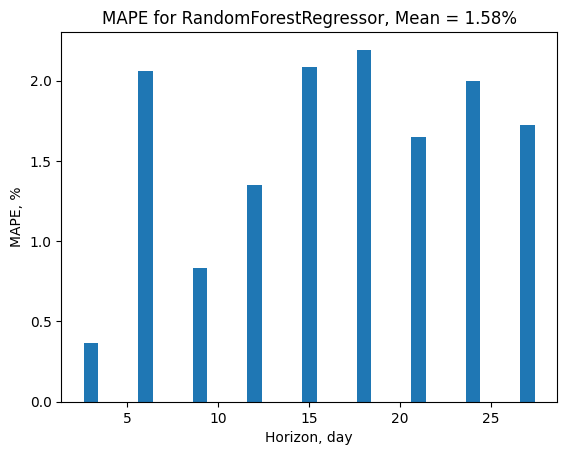

In [44]:
rf = train_model(data_lagged, RandomForestRegressor(), stride=3,  cols=cols)

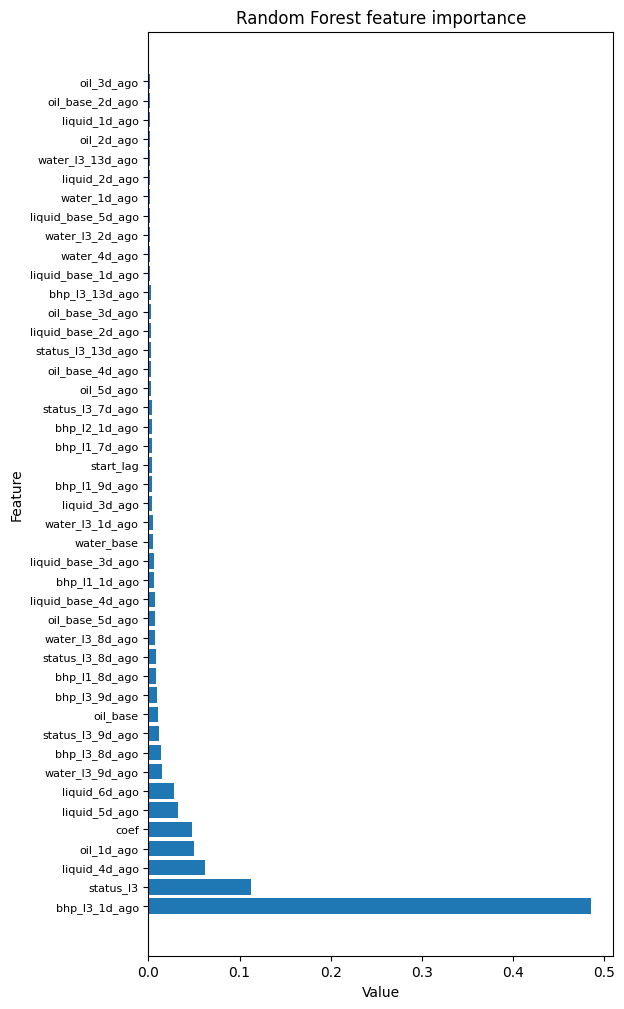

In [45]:
feats1 = plot_importances(rf, top=50)

In [76]:
from itertools import product
from tqdm import tqdm

class GridCV:
    def __init__(self, 
                 model, 
                 params, 
                 cv=5,
                 test_size=3):
        
        self.model = model
        self.params = params
        self.cv = cv
        self.test_size = test_size

    def _get_param_len(self):
        param_len = 1

        for param in self.params.values():
            param_len *= len(param)

        return param_len
    
    def _train_estimator(self, data, horizon, cols):    
        train = data[data.date < horizon]
        test = data[(data.date >= horizon) & (data.date < horizon + 3)]

        for days_past, day in enumerate(test.date.unique()):
            for col in test.columns:
                for past in range(days_past + 1):
                    if f'{past}d_ago' in col:
                        test.loc[test.date == day, col] = -1
        
        if cols is None:
            cols = data.columns.tolist()
            for col in ['oil', 'water', 'liquid', 'delta_baseline']:
                cols.remove(col)

        self.model.fit(X=train[cols], y=train.delta_baseline)
        y_pred = self.model.predict(test[cols])    
        return mean_absolute_percentage_error(test.oil, y_pred + test.oil_base) * 100
    
    def _cv(self, data, cols):
        mapes = [self._train_estimator(data, i, cols) for i in range(2, 27, 3)]
        return np.mean(mapes)
    
    def get_parameters(self):
        return (dict(zip(self.params.keys(), values)) for values in product(*self.params.values()))

    def fit(self, data, cols):
        best_score = np.inf
        best_params = None
        
        with tqdm(self.get_parameters(), total=self._get_param_len()) as pbar:
            for params in pbar:
                self.model.set_params(**params)
                score = self._cv(data, cols)
                
                if score < best_score:
                    best_score = score
                    best_params = params

                pbar.set_postfix({'best_score': best_score, 'best_params': best_params})
                
        self.model.set_params(**best_params)
        self.model.fit(data[cols], data.delta_baseline)
        
        return self

In [77]:
tscv = TimeSeriesSplit(n_splits=SPLITS, test_size=HORIZON)

params = {'n_estimators': [100, 300],
          'max_depth': [5, 10],
          'min_samples_split': [2, 3, 5],
          'min_samples_leaf': [2, 3, 5],
          'max_features': [None, 0.5, 'sqrt']}

rf = RandomForestRegressor()
    
grid = GridCV(model=rf, 
              params=params)

grid.fit(data_lagged, cols=cols)
 

100%|██████████| 108/108 [31:26<00:00, 17.47s/it, best_score=1.64, best_params={'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}]


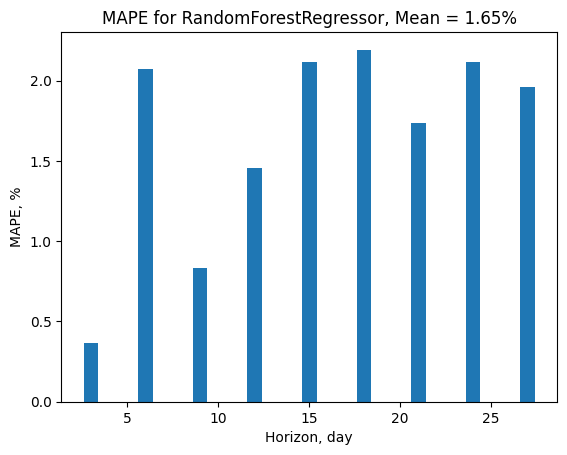

In [78]:
rf = train_model(data_lagged, RandomForestRegressor(**grid.model.get_params()), stride=3, cols=cols)

In [81]:
def pred_ints(model: RandomForestRegressor, X: pd.DataFrame, percentile=95):
    err_down = []
    err_up = []
    
    for x in range(len(X)):
        preds = [pred.predict(np.array(X.iloc[x], ndmin=2)) for pred in model.estimators_]
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))

    return np.array(err_down), np.array(err_up)

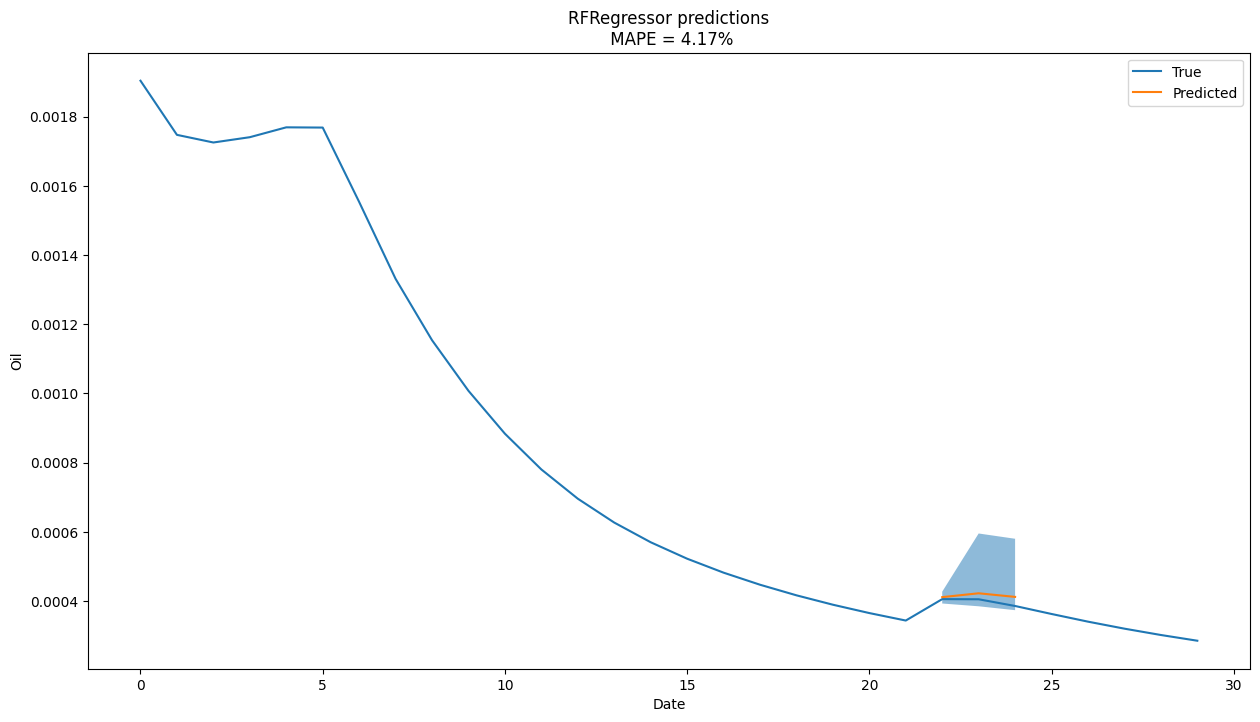

In [102]:
DATE = 22
HORIZON = 3
COEF = 0.5
LAG = 21
CAT = 2

train = data_lagged[(data_lagged.date < DATE) &
                    (data_lagged.coef == COEF) &
                    (data_lagged.cat == CAT)]

test = data_lagged[(data_lagged.date >= DATE) & (data_lagged.date < DATE + HORIZON) &
                    (data_lagged.coef == COEF) &
                    (data_lagged.start_lag == LAG) &
                    (data_lagged.cat == CAT)]

for days_past, day in enumerate(test.date.unique()):
    for col in test.columns:
        for past in range(days_past + 1):
            if f'{past}d_ago' in col:
                test.loc[test.date == day, col] = -1

X_sample = test[cols]
y_sample = test.delta_baseline

X_train = train[cols]
y_train = train.delta_baseline
rf.fit(X_train, y_train)

sample_pred = rf.predict(X_sample)
sample_lower, sample_upper = pred_ints(rf, X_sample, percentile=95)

sample_true = data_lagged[(data_lagged.start_lag == LAG) &
                          (data_lagged.coef == COEF) &
                          (data_lagged.cat == CAT)]

plt.figure(figsize=(15, 8))
plt.plot(sample_true.date, - sample_true.oil, label='True')
plt.plot(test.date, - sample_pred - test.oil_base, label='Predicted')
plt.fill_between(test.date, - sample_lower - test.oil_base, - sample_upper - test.oil_base, alpha=0.5)

plt.title(f'RFRegressor predictions\
\n MAPE = {mean_absolute_percentage_error(test.oil, sample_pred + test.oil_base) * 100:.2f}%')
plt.xlabel('Date')
plt.ylabel('Oil')
plt.legend()
plt.show()